In [1]:
import numpy as np
import torch
import os
import random
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import nibabel as nib

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
import torchvision.models as models
import copy

In [2]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
 
        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)
 
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x): 
        # the shape of x is (b c h w)
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        attn = self.sigmoid(out) # (b c)
        attn = torch.squeeze(attn, dim=3)
        attn = torch.squeeze(attn, dim=2)
        x = x * attn[:, :, None, None]
        return x
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
 
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
 
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x): 
        # the shape of x is (b c h w)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv1(attn) # b 1 h w
        attn = self.sigmoid(attn)
        attn = torch.squeeze(attn, dim=1) # b h w
        x = attn[:, None, :, :] * x
        return x

In [3]:
random.seed(3407)
rmb_label = {"ASD": 0, "TD": 1}      # 设置标签

class MultiModalDataset(Dataset):
    def __init__(self, data_dirho, data_diraal,data_direz , data_dircsv, transform=None):
        """ 
        ABIDE_db的Dataset
        :param data_dir: str, 数据集所在路径
        :param transform: torch.transform，数据预处理
        """
        self.label_name = {"ASD": 0, "TD": 1}
        self.data_infocsv = self.get_csv_info(data_dircsv)  # data_info存储所有txt路径和标签，在DataLoader中通过index读取样本
        self.data_infoez = self.get_1D_info(data_direz)  # data_info存储所有txt路径和标签，在DataLoader中通过index读取样本
        self.data_infoho = self.get_1D_info(data_dirho)
        self.data_infoaal = self.get_1D_info(data_diraal)

        self.transform = transform
        

        
    def __getitem__(self, index):
        path_csv, label_csv = self.data_infocsv[index]
        txt_data = np.loadtxt(path_csv, delimiter=',')
        label = label_csv
        csv = torch.from_numpy(txt_data).float().unsqueeze(0)
        ez = self.process_data(method='ez',index=index,labels=label_csv)
        ho = self.process_data(method='ho',index=index,labels=label_csv)
        aal = self.process_data(method='aal',index=index,labels=label_csv)

        if self.transform is not None:
            txt = 1   # 在这里做transform，转为tensor等等

        return ho,aal,ez,csv,label

    def __len__(self):
        return len(self.data_infocsv)

    @staticmethod
    def get_csv_info(data_dir):
        data_infocsv = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                txt_names = os.listdir(os.path.join(root, sub_dir))
                txt_names = list(filter(lambda x: x.endswith('.csv'), txt_names))

                # 遍历txt
                for i in range(len(txt_names)):
                    txt_name = txt_names[i]
                    path_txt = os.path.join(root, sub_dir, txt_name)
                    label = rmb_label[sub_dir]
                    data_infocsv.append((path_txt, int(label)))
                    data_infocsv = sorted(data_infocsv)

        return data_infocsv
    
    def get_1D_info(self,data_dir):
        data_infonii = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                txt_names = os.listdir(os.path.join(root, sub_dir))
                txt_names = list(filter(lambda x: x.endswith('.1D'), txt_names))

                # 遍历txt
                for i in range(len(txt_names)):
                    txt_name = txt_names[i]
                    path_txt = os.path.join(root, sub_dir, txt_name)
                    label = rmb_label[sub_dir]
                    data_infonii.append((path_txt, int(label)))
                    data_infonii = sorted(data_infonii)
        return data_infonii
    
    def process_data(self,method,index,labels):
        if method == 'ez':
            path, label = self.data_infoez[index]
            txt_data = np.loadtxt(path)
            cor = np.corrcoef(txt_data.T)
            cor = torch.from_numpy(cor).float().unsqueeze(0)
        if method == 'ho':
            path, label = self.data_infoho[index]
            txt_data = np.loadtxt(path)
            cor = np.corrcoef(txt_data.T)
            file1 = np.pad(cor, ((0, 5), (0, 5)), mode='constant')
            cor = torch.from_numpy(file1).float().unsqueeze(0)
        if method == 'aal':
            path, label = self.data_infoaal[index]
            txt_data = np.loadtxt(path)
            cor = np.corrcoef(txt_data.T)
            cor = torch.from_numpy(cor).float().unsqueeze(0)
        if labels != label:
            print('Error: label not match!')
            print('the error 1D:{}',path)
        
        
        return cor

In [4]:
class SimpleCNN_aal(nn.Module):
    def __init__(self):
        super(SimpleCNN_aal, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 29 * 29, 128)
        self.fc2 = nn.Linear(128, 2)

        self.channel_attention2 = ChannelAttention(32)
    
        self.spatial_attention2 = SpatialAttention()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        
        # Apply channel attention and spatial attention after conv2
        x = self.channel_attention2(x)
        x = self.spatial_attention2(x)

        x = self.pool(x)
        x = x.view(-1, 32 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
csv_split_dir = os.path.join('easy/not modify/csv_split')  
csv_train_dir = os.path.join(csv_split_dir, "train")
csv_valid_dir = os.path.join(csv_split_dir, "valid")
csv_test_dir  = os.path.join(csv_split_dir, "test") 
aal_split_dir = os.path.join('easy/not modify/aal_split')  
aal_train_dir = os.path.join(aal_split_dir, "train")
aal_valid_dir = os.path.join(aal_split_dir, "valid")
aal_test_dir  = os.path.join(aal_split_dir, "test") 
ho_split_dir = os.path.join('easy/not modify/rho_split')  
ho_train_dir = os.path.join(ho_split_dir, "train")
ho_valid_dir = os.path.join(ho_split_dir, "valid")
ho_test_dir  = os.path.join(ho_split_dir, "test") 
ez_split_dir = os.path.join('easy/not modify/ez_split')  
ez_train_dir = os.path.join(ez_split_dir, "train")
ez_valid_dir = os.path.join(ez_split_dir, "valid")
ez_test_dir  = os.path.join(ez_split_dir, "test") 

# aal


训练
Epoch [1/70], Train Loss: 0.7182, Train Accuracy: 0.4789, Validation Loss: 0.6981, Validation Accuracy: 0.4647
Epoch [2/70], Train Loss: 0.6947, Train Accuracy: 0.5076, Validation Loss: 0.6912, Validation Accuracy: 0.5353
Epoch [3/70], Train Loss: 0.6877, Train Accuracy: 0.5346, Validation Loss: 0.6908, Validation Accuracy: 0.5471
Epoch [4/70], Train Loss: 0.6859, Train Accuracy: 0.5717, Validation Loss: 0.6883, Validation Accuracy: 0.5353
Epoch [5/70], Train Loss: 0.6798, Train Accuracy: 0.5346, Validation Loss: 0.6861, Validation Accuracy: 0.5353
Epoch [6/70], Train Loss: 0.6727, Train Accuracy: 0.6509, Validation Loss: 0.6853, Validation Accuracy: 0.5353
Epoch [7/70], Train Loss: 0.6630, Train Accuracy: 0.5481, Validation Loss: 0.6853, Validation Accuracy: 0.5588
Epoch [8/70], Train Loss: 0.6478, Train Accuracy: 0.6998, Validation Loss: 0.6842, Validation Accuracy: 0.5529
Epoch [9/70], Train Loss: 0.6301, Train Accuracy: 0.6644, Validation Loss: 0.6765, Validation Accuracy: 0.552

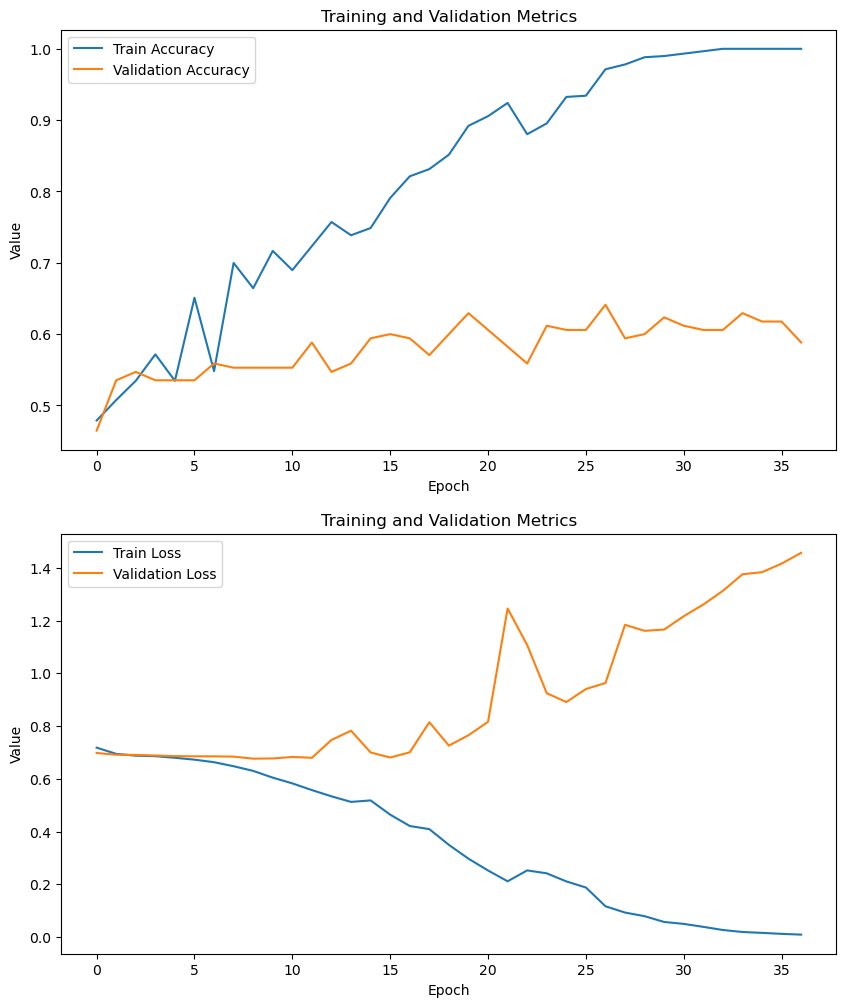

Bestloss
Accuracy: 0.5465
Sensitivity: 0.6522
Specificity: 0.4250
Positive Predictive Value: 0.5660
Negative Predictive Value: 0.5152

Bestacc
Accuracy: 0.5465
Sensitivity: 0.6522
Specificity: 0.4250
Positive Predictive Value: 0.5660
Negative Predictive Value: 0.5152


In [6]:
#aal
# 定义超参数

input_size = [116,116]
batch_size = 128
learning_rate = 0.001
num_epochs = 70
num_classes = 2
log_interval = 8
val_interval = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN_aal()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

# 实例化数据集和数据加载器

train_dataset = MultiModalDataset(ho_train_dir,aal_train_dir,ez_train_dir,csv_train_dir, transform=None)
valid_dataset = MultiModalDataset(ho_valid_dir,aal_valid_dir,ez_valid_dir,csv_valid_dir, transform=None)
test_dataset = MultiModalDataset(ho_test_dir,aal_test_dir,ez_test_dir,csv_test_dir, transform=None)
#CNN 图像模型dataloader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn = collate_fn,num_workers = num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn = collate_fn,num_workers = num_workers)
#非CNN 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print('训练')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
# 初始化
best_val_loss = float('inf')
best_val_acc = 0.0
loss_patience = 10
acc_patience = 10
loss_count = 0
acc_count = 0
model_bestloss = None
model_bestacc = None

# ============================ step 5/5 训练 ============================
# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (ho,aal,ez,csv,label) in enumerate(train_loader):
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
        optimizer.zero_grad()
        outputs = model(aal)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * csv.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for ho,aal,ez,csv,label in valid_loader:
            ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
            outputs = model(aal)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * csv.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # pred = outputs.argmax(dim=1)
            # print(f"Sample: predicted={pred.item()}, target={label.item()},matched?={label.item() == pred.item()}")

    valid_loss = running_loss / len(valid_dataset)
    valid_acc = correct / total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # 打印训练过程中的指标
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    # 保存模型
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        model_bestloss = copy.deepcopy(model)
        loss_count = 0
    else:
        loss_count += 1

    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        model_bestacc = copy.deepcopy(model)
        acc_count = 0
    else:
        acc_count += 1

    # 如果损失连续增加，且准确率不再增加，则停止训练
    if loss_count >= loss_patience and acc_count >= acc_patience:
        print("Early stopping triggered.")
        break

# 保存最佳模型
torch.save(model_bestacc.state_dict(), 'pth/accmodel_aal_notmodify_2attention.pth')
torch.save(model_bestloss.state_dict(), 'pth/lossmodel_aal_notmodify_2attention.pth')

# 绘制训练和验证指标的图表
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(train_accs, label='Train Accuracy')
axs[0].plot(valid_accs, label='Validation Accuracy')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].set_title('Training and Validation Metrics')

axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(valid_losses, label='Validation Loss')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].set_title('Training and Validation Metrics')

plt.show()

# 在测试阶段，我们需要跟踪的指标
TP = 0
TN = 0
FP = 0
FN = 0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 开始测试
print('Bestloss')
model_bestloss.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(aal)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

print('\nBestacc')
TP = 0
TN = 0
FP = 0
FN = 0
model_bestacc.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(aal)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

# Ho

In [7]:
class SimpleCNN_ho(nn.Module):
    def __init__(self):
        super(SimpleCNN_ho, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 29 * 29, 128)
        self.fc2 = nn.Linear(128, 2)

        self.channel_attention2 = ChannelAttention(32)
    
        self.spatial_attention2 = SpatialAttention()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        
        # Apply channel attention and spatial attention after conv2
        x = self.channel_attention2(x)
        x = self.spatial_attention2(x)

        x = self.pool(x)
        x = x.view(-1, 32 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

训练
Epoch [1/50], Train Loss: 0.7063, Train Accuracy: 0.5025, Validation Loss: 0.6959, Validation Accuracy: 0.4647
Epoch [2/50], Train Loss: 0.6881, Train Accuracy: 0.5245, Validation Loss: 0.6934, Validation Accuracy: 0.5353
Epoch [3/50], Train Loss: 0.6922, Train Accuracy: 0.5346, Validation Loss: 0.6901, Validation Accuracy: 0.5353
Epoch [4/50], Train Loss: 0.6818, Train Accuracy: 0.6189, Validation Loss: 0.6904, Validation Accuracy: 0.5824
Epoch [5/50], Train Loss: 0.6768, Train Accuracy: 0.6358, Validation Loss: 0.6902, Validation Accuracy: 0.5353
Epoch [6/50], Train Loss: 0.6691, Train Accuracy: 0.5868, Validation Loss: 0.6881, Validation Accuracy: 0.5353
Epoch [7/50], Train Loss: 0.6528, Train Accuracy: 0.5481, Validation Loss: 0.6863, Validation Accuracy: 0.5412
Epoch [8/50], Train Loss: 0.6344, Train Accuracy: 0.7116, Validation Loss: 0.6826, Validation Accuracy: 0.5647
Epoch [9/50], Train Loss: 0.6092, Train Accuracy: 0.7116, Validation Loss: 0.6801, Validation Accuracy: 0.588

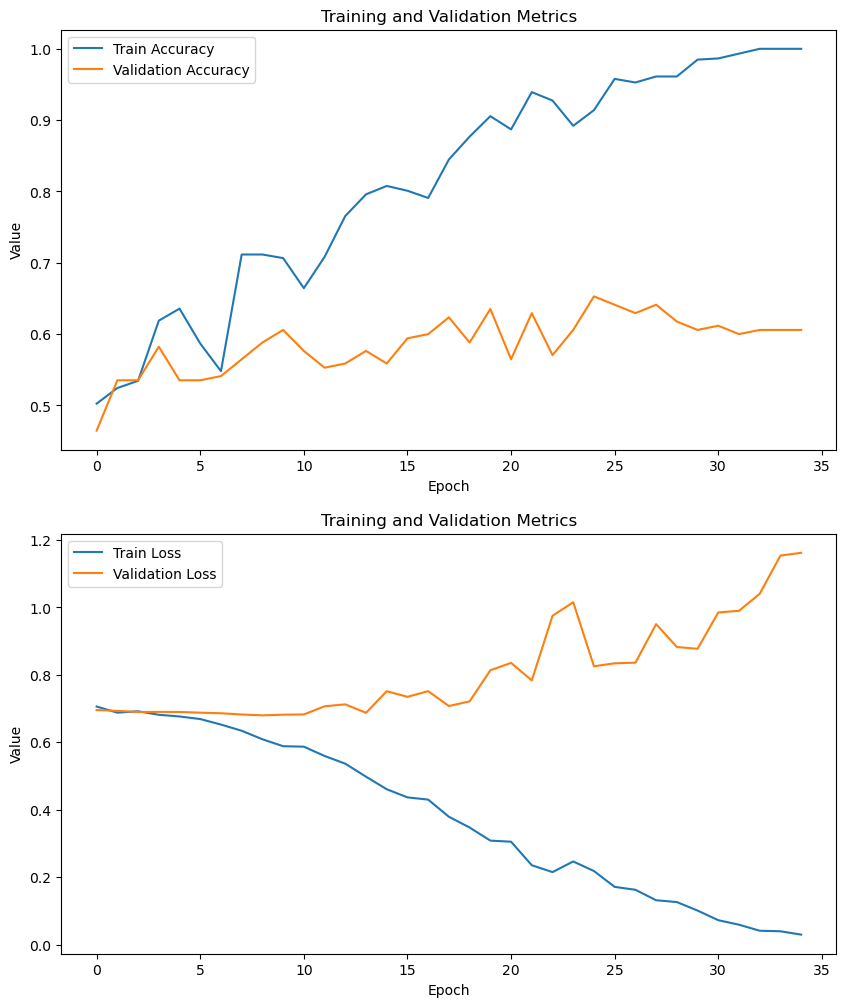

Bestloss
Accuracy: 0.6279
Sensitivity: 0.8261
Specificity: 0.4000
Positive Predictive Value: 0.6129
Negative Predictive Value: 0.6667

Bestacc
Accuracy: 0.5698
Sensitivity: 0.9130
Specificity: 0.1750
Positive Predictive Value: 0.5600
Negative Predictive Value: 0.6364


In [8]:
#aal
# 定义超参数

input_size = [116,116]
batch_size = 128
learning_rate = 0.001
num_epochs = 50
num_classes = 2
log_interval = 8
val_interval = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN_ho()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

# 实例化数据集和数据加载器

train_dataset = MultiModalDataset(ho_train_dir,aal_train_dir,ez_train_dir,csv_train_dir, transform=None)
valid_dataset = MultiModalDataset(ho_valid_dir,aal_valid_dir,ez_valid_dir,csv_valid_dir, transform=None)
test_dataset = MultiModalDataset(ho_test_dir,aal_test_dir,ez_test_dir,csv_test_dir, transform=None)
#CNN 图像模型dataloader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn = collate_fn,num_workers = num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn = collate_fn,num_workers = num_workers)
#非CNN 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print('训练')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
# 初始化
best_val_loss = float('inf')
best_val_acc = 0.0
loss_patience = 10
acc_patience = 10
loss_count = 0
acc_count = 0
model_bestloss = None
model_bestacc = None

# ============================ step 5/5 训练 ============================
# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (ho,aal,ez,csv,label) in enumerate(train_loader):
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
        optimizer.zero_grad()
        outputs = model(ho)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * csv.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for ho,aal,ez,csv,label in valid_loader:
            ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
            outputs = model(ho)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * csv.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # pred = outputs.argmax(dim=1)
            # print(f"Sample: predicted={pred.item()}, target={label.item()},matched?={label.item() == pred.item()}")

    valid_loss = running_loss / len(valid_dataset)
    valid_acc = correct / total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # 打印训练过程中的指标
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    # 保存模型
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        model_bestloss = copy.deepcopy(model)
        loss_count = 0
    else:
        loss_count += 1

    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        model_bestacc = copy.deepcopy(model)
        acc_count = 0
    else:
        acc_count += 1

    # 如果损失连续增加，且准确率不再增加，则停止训练
    if loss_count >= loss_patience and acc_count >= acc_patience:
        print("Early stopping triggered.")
        break

# 保存最佳模型
torch.save(model_bestacc.state_dict(), 'pth/accmodel_ho_notmodify_2attention.pth')
torch.save(model_bestloss.state_dict(), 'pth/lossmodel_ho_notmodify_2attention.pth')

# 绘制训练和验证指标的图表
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(train_accs, label='Train Accuracy')
axs[0].plot(valid_accs, label='Validation Accuracy')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].set_title('Training and Validation Metrics')

axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(valid_losses, label='Validation Loss')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].set_title('Training and Validation Metrics')

plt.show()

# 在测试阶段，我们需要跟踪的指标
TP = 0
TN = 0
FP = 0
FN = 0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 开始测试
print('Bestloss')
model_bestloss.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(ho)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

print('\nBestacc')
TP = 0
TN = 0
FP = 0
FN = 0
model_bestacc.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(aal)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

# ez

In [9]:
class SimpleCNN_ez(nn.Module):
    def __init__(self):
        super(SimpleCNN_ez, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 29 * 29, 128)
        self.fc2 = nn.Linear(128, 2)

        self.channel_attention2 = ChannelAttention(32)
    
        self.spatial_attention2 = SpatialAttention()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        
        # Apply channel attention and spatial attention after conv2
        x = self.channel_attention2(x)
        x = self.spatial_attention2(x)

        x = self.pool(x)
        x = x.view(-1, 32 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

训练
Epoch [1/50], Train Loss: 0.7344, Train Accuracy: 0.4739, Validation Loss: 0.6936, Validation Accuracy: 0.5353
Epoch [2/50], Train Loss: 0.6914, Train Accuracy: 0.5346, Validation Loss: 0.6910, Validation Accuracy: 0.5353
Epoch [3/50], Train Loss: 0.6901, Train Accuracy: 0.5346, Validation Loss: 0.6903, Validation Accuracy: 0.5353
Epoch [4/50], Train Loss: 0.6893, Train Accuracy: 0.5346, Validation Loss: 0.6899, Validation Accuracy: 0.5353
Epoch [5/50], Train Loss: 0.6872, Train Accuracy: 0.5346, Validation Loss: 0.6893, Validation Accuracy: 0.5353
Epoch [6/50], Train Loss: 0.6842, Train Accuracy: 0.5346, Validation Loss: 0.6885, Validation Accuracy: 0.5353
Epoch [7/50], Train Loss: 0.6805, Train Accuracy: 0.5396, Validation Loss: 0.6870, Validation Accuracy: 0.5353
Epoch [8/50], Train Loss: 0.6719, Train Accuracy: 0.5531, Validation Loss: 0.6846, Validation Accuracy: 0.5412
Epoch [9/50], Train Loss: 0.6619, Train Accuracy: 0.6037, Validation Loss: 0.6818, Validation Accuracy: 0.547

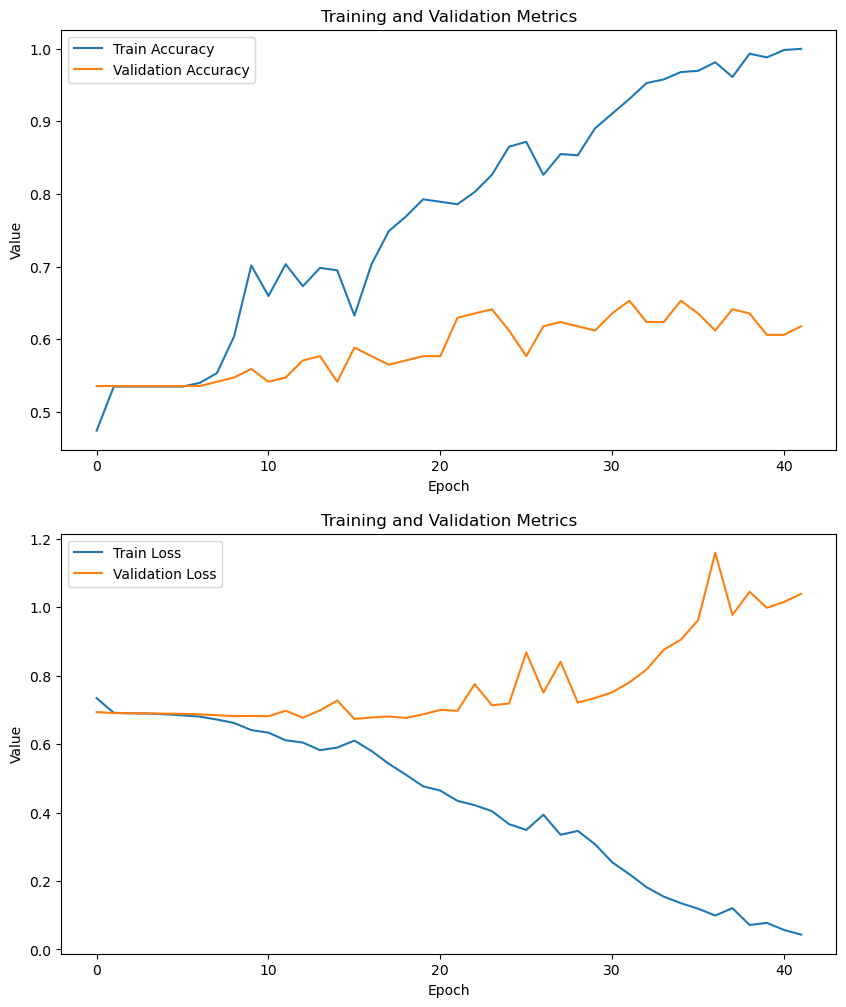

Bestloss
Accuracy: 0.4651
Sensitivity: 0.0870
Specificity: 0.9000
Positive Predictive Value: 0.5000
Negative Predictive Value: 0.4615

Bestacc
Accuracy: 0.5698
Sensitivity: 0.5870
Specificity: 0.5500
Positive Predictive Value: 0.6000
Negative Predictive Value: 0.5366


In [10]:
# 定义超参数
input_size = [116,116]
batch_size = 128
learning_rate = 0.001
num_epochs = 50
num_classes = 2
log_interval = 8
val_interval = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN_ez()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

# 实例化数据集和数据加载器

train_dataset = MultiModalDataset(ho_train_dir,aal_train_dir,ez_train_dir,csv_train_dir, transform=None)
valid_dataset = MultiModalDataset(ho_valid_dir,aal_valid_dir,ez_valid_dir,csv_valid_dir, transform=None)
test_dataset = MultiModalDataset(ho_test_dir,aal_test_dir,ez_test_dir,csv_test_dir, transform=None)
#CNN 图像模型dataloader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn = collate_fn,num_workers = num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn = collate_fn,num_workers = num_workers)
#非CNN 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print('训练')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_val_loss = float('inf')
best_val_acc = 0.0
loss_patience = 10
acc_patience = 10
loss_count = 0
acc_count = 0
model_bestloss = None
model_bestacc = None
# ============================ step 5/5 训练 ============================
# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (ho,aal,ez,csv,label) in enumerate(train_loader):
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
        optimizer.zero_grad()
        outputs = model(ez)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * csv.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for ho,aal,ez,csv,label in valid_loader:
            ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
            outputs = model(ez)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * csv.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # pred = outputs.argmax(dim=1)
            # print(f"Sample: predicted={pred.item()}, target={label.item()},matched?={label.item() == pred.item()}")

    valid_loss = running_loss / len(valid_dataset)
    valid_acc = correct / total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # 打印训练过程中的指标
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    # 保存模型
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        model_bestloss = copy.deepcopy(model)
        loss_count = 0
    else:
        loss_count += 1

    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        model_bestacc = copy.deepcopy(model)
        acc_count = 0
    else:
        acc_count += 1

    # 如果损失连续增加，且准确率不再增加，则停止训练
    if loss_count >= loss_patience and acc_count >= acc_patience:
        print("Early stopping triggered.")
        break

# 保存最佳模型
torch.save(model_bestacc.state_dict(), 'pth/accmodel_ez_notmodify_2attention.pth')
torch.save(model_bestloss.state_dict(), 'pth/lossmodel_ez_notmodify_2attention.pth')

# 绘制训练和验证指标的图表
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(train_accs, label='Train Accuracy')
axs[0].plot(valid_accs, label='Validation Accuracy')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].set_title('Training and Validation Metrics')

axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(valid_losses, label='Validation Loss')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].set_title('Training and Validation Metrics')

plt.show()

# 在测试阶段，我们需要跟踪的指标
TP = 0
TN = 0
FP = 0
FN = 0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 开始测试
print('Bestloss')
model_bestloss.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(ho)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

print('\nBestacc')
TP = 0
TN = 0
FP = 0
FN = 0
model_bestacc.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(aal)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

# csv

In [11]:
class SimpleCNN_csv(nn.Module):
    def __init__(self):
        super(SimpleCNN_csv, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 29 * 29, 128)
        self.fc2 = nn.Linear(128, 2)

        self.channel_attention2 = ChannelAttention(32)
    
        self.spatial_attention2 = SpatialAttention()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        
        # Apply channel attention and spatial attention after conv2
        x = self.channel_attention2(x)
        x = self.spatial_attention2(x)

        x = self.pool(x)
        x = x.view(-1, 32 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

训练
Epoch [1/50], Train Loss: 0.8039, Train Accuracy: 0.5143, Validation Loss: 0.7099, Validation Accuracy: 0.5353
Epoch [2/50], Train Loss: 0.6894, Train Accuracy: 0.5346, Validation Loss: 0.6925, Validation Accuracy: 0.5471
Epoch [3/50], Train Loss: 0.6924, Train Accuracy: 0.4941, Validation Loss: 0.6937, Validation Accuracy: 0.4647
Epoch [4/50], Train Loss: 0.6921, Train Accuracy: 0.5363, Validation Loss: 0.6923, Validation Accuracy: 0.5529
Epoch [5/50], Train Loss: 0.6906, Train Accuracy: 0.5497, Validation Loss: 0.6915, Validation Accuracy: 0.5353
Epoch [6/50], Train Loss: 0.6897, Train Accuracy: 0.5346, Validation Loss: 0.6910, Validation Accuracy: 0.5353
Epoch [7/50], Train Loss: 0.6879, Train Accuracy: 0.5363, Validation Loss: 0.6906, Validation Accuracy: 0.5353
Epoch [8/50], Train Loss: 0.6856, Train Accuracy: 0.5363, Validation Loss: 0.6893, Validation Accuracy: 0.5353
Epoch [9/50], Train Loss: 0.6806, Train Accuracy: 0.5363, Validation Loss: 0.6884, Validation Accuracy: 0.541

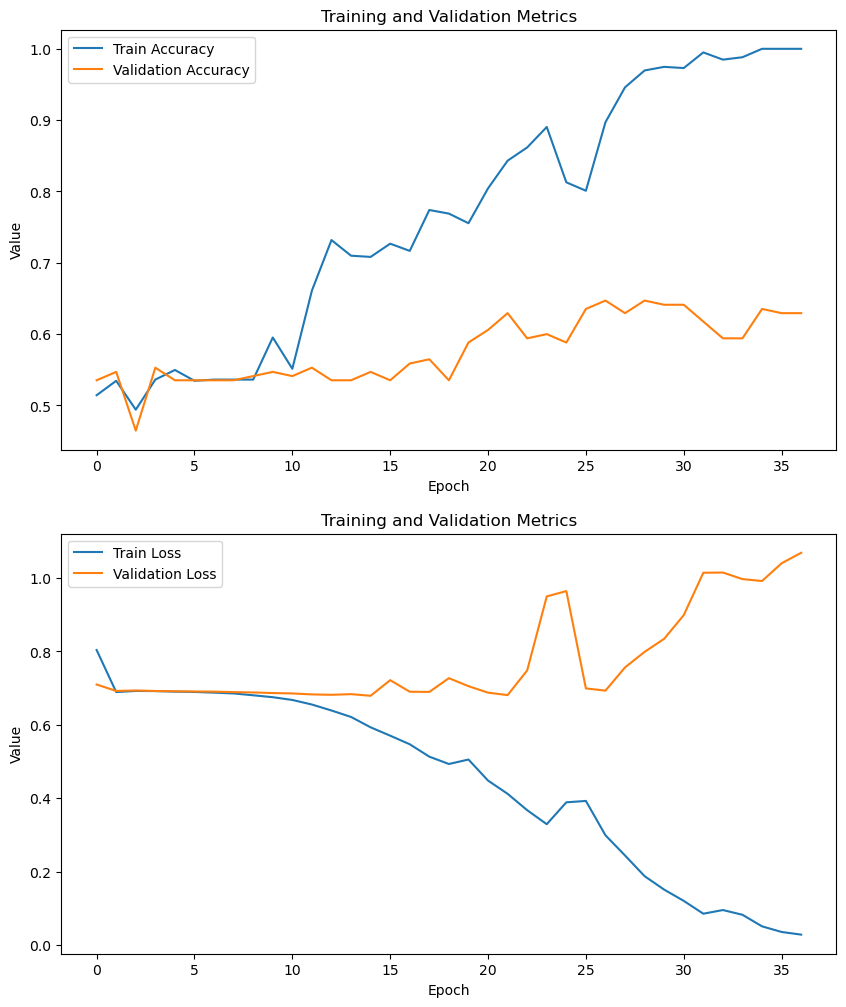

Bestloss
Accuracy: 0.6163
Sensitivity: 0.5000
Specificity: 0.7500
Positive Predictive Value: 0.6970
Negative Predictive Value: 0.5660

Bestacc
Accuracy: 0.6047
Sensitivity: 0.6087
Specificity: 0.6000
Positive Predictive Value: 0.6364
Negative Predictive Value: 0.5714


In [12]:
# 定义超参数
input_size = [116,116]
batch_size = 128
learning_rate = 0.001
num_epochs = 50
num_classes = 2
log_interval = 8
val_interval = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN_csv()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

# 实例化数据集和数据加载器

train_dataset = MultiModalDataset(ho_train_dir,aal_train_dir,ez_train_dir,csv_train_dir, transform=None)
valid_dataset = MultiModalDataset(ho_valid_dir,aal_valid_dir,ez_valid_dir,csv_valid_dir, transform=None)
test_dataset = MultiModalDataset(ho_test_dir,aal_test_dir,ez_test_dir,csv_test_dir, transform=None)
#CNN 图像模型dataloader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn = collate_fn,num_workers = num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn = collate_fn,num_workers = num_workers)
#非CNN 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print('训练')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_val_loss = float('inf')
best_val_acc = 0.0
loss_patience = 10
acc_patience = 10
loss_count = 0
acc_count = 0
model_bestloss = None
model_bestacc = None
# =====================
# ============================ step 5/5 训练 ============================
# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (ho,aal,ez,csv,label) in enumerate(train_loader):
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
        optimizer.zero_grad()
        outputs = model(csv)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * csv.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for ho,aal,ez,csv,label in valid_loader:
            ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
            outputs = model(csv)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * csv.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # pred = outputs.argmax(dim=1)
            # print(f"Sample: predicted={pred.item()}, target={label.item()},matched?={label.item() == pred.item()}")

    valid_loss = running_loss / len(valid_dataset)
    valid_acc = correct / total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # 打印训练过程中的指标
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    # 保存模型
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        model_bestloss = copy.deepcopy(model)
        loss_count = 0
    else:
        loss_count += 1

    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        model_bestacc = copy.deepcopy(model)
        acc_count = 0
    else:
        acc_count += 1

    # 如果损失连续增加，且准确率不再增加，则停止训练
    if loss_count >= loss_patience and (acc_count >= acc_patience and epoch > 30):
        print("Early stopping triggered.")
        break

# 保存最佳模型
torch.save(model_bestacc.state_dict(), 'pth/accmodel_csv_notmodify_2attention.pth')
torch.save(model_bestloss.state_dict(), 'pth/lossmodel_csv_notmodify_2attention.pth')

# 绘制训练和验证指标的图表
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(train_accs, label='Train Accuracy')
axs[0].plot(valid_accs, label='Validation Accuracy')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].set_title('Training and Validation Metrics')

axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(valid_losses, label='Validation Loss')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].set_title('Training and Validation Metrics')

plt.show()

model_save_path = "pth/model_csv_notmodify_attention.pth"
torch.save(model.state_dict(), model_save_path)
# 在测试阶段，我们需要跟踪的指标
TP = 0
TN = 0
FP = 0
FN = 0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 开始测试
print('Bestloss')
model_bestloss.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(ho)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

print('\nBestacc')
TP = 0
TN = 0
FP = 0
FN = 0
model_bestacc.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(aal)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")